In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, io, filters, util, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_ubyte
from sklearn.metrics import accuracy_score

import os

0


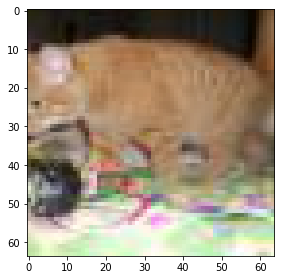

In [2]:
with h5py.File('c-d-ds-small.hdf5', 'r') as f:
#with h5py.File('c-d-ds.hdf5', 'r') as f:
    X_train_org = f['X_train'][:,:,:,:]
    y_train_org = f['y_train'][:]
    X_test_org =  f['X_test'][:,:,:,:]
    y_test_org =  f['y_test'][:]

io.imshow(X_train_org[69,:,:,:])    
print(y_train_org[69])


In [3]:
y_train = np.expand_dims(y_train_org, axis=1)
X_train = X_train_org.reshape(X_train_org.shape[0], -1) / 256

y_test = np.expand_dims(y_test_org, axis=1)
X_test = X_test_org.reshape(X_test_org.shape[0], -1) / 256

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 12288), (1000, 1), (200, 12288), (200, 1))

In [4]:
# вспомогательные функции
def relu(X):
    return np.maximum(0, X)

def relu_der(X):
    return np.maximum(0, X) / X

def sigmoid(X):
    Y = 1./ (1 + np.exp(-X))
    return Y

def sigmoid_der(X):
    Y = sigmoid(X) * (1 - sigmoid(X))
    return Y

def loss(a, y):
    # loss - бинарная кроссэнтропия 
    return -(y*np.log(a) + (1-y)*np.log(1-a))

def L(a, y):
    # cost function - ее оптимизируем
    #print('a = \n', a, "\n")
    #print('y = \n', y, "\n")
    return -(1./y.shape[1]) * np.sum(loss(a, y))


In [12]:
class NeuralNetwork():
    
    def __init__(self, shapes, activations, debug=False):
        # shapes - список числа нейронов в слоях кроме последнего, 1-й - размерность входа
        self.shapes = shapes
        self.layers = len(shapes) -1
        self.activations = activations
        self.debug = debug
        self._init_params()
        self.losses_train = []
        self.acc_test = []
        self.acc_train = []
        

    
    def _init_params(self, type='rand'):
        if type == 'rand':
            self.W = []
            self.b = []
            for i in range(1, len(self.shapes)):
                self.W.append(np.random.randn(self.shapes[i], self.shapes[i-1]) *0.01)
                self.b.append(np.zeros((self.shapes[i], 1)))

        if self.debug:
            print('--- Матрицы параметров ---')        
            for W, b in zip(self.W, self.b):
                print(W.shape, b.shape)
            print('--------------------------')        
            
    def normalize_input(self, X, train=True):
        if train:
            self.mu = np.mean(X)
            self.sigma = np.var(X)
        return (X - self.mu) / self.sigma
        
        
    def _forward_pass(self, X):
        # делаем без батчей - сразу весь кусок что есть, надеюсь не подавимся
        A = X
        cache = [(X, X)] # она понадобится чтобы посчитать градиент по ней для первого слоя
        for W, b, activation in list(zip(self.W, self.b, self.activations)):
            Z = np.dot(W, A) + b
            A = activation(Z)
            cache.append((A,Z)) 
        return A, cache
            
    def _backward_pass(self, cache, dL):
        # chache содержит все активации по всем слоям, dA - это производная 
        dW_arr = []
        db_arr = []

        dA = dL
        m = dA.shape[1]

        # они идут от 1-го слоя к последнему, а нам надо наоборот
        for i in range(self.layers):
            if self.debug:
                print(self.layers - i - 1)
                
            # смотрим что в этом слое активация и какая у нее производная
            if self.activations[self.layers - i - 1] == sigmoid:
                actitation_der = sigmoid_der
            if self.activations[self.layers - i - 1] == relu:
                actitation_der = relu_der

            Z = cache[self.layers - i][1]                
            dZ = actitation_der(Z) * dA
            if self.debug:
                print('dZ.shape=',dZ.shape)
            
            db = np.expand_dims((1./m) * np.sum(dZ, axis=1), axis=0).T
            db_arr.append(db)
            if self.debug:            
                print('db.shape=',db.shape)
                
            dW = (1./m) * np.dot(dZ, cache[self.layers-i-1][0].T) 
            dW_arr.append(dW)
            if self.debug:            
                print('W.[self.layers - ',i-1,']', self.W[self.layers - i -1].T.shape)
                print('dW.shape=',dW.shape, 'cache[self.layers-',i,'-1][0].T',cache[self.layers-i-1][0].shape)

            dA = np.dot(self.W[self.layers-i-1].T, dZ) 
            if self.debug:
                print('dA.shape=', dA.shape)
        
        dW_arr.reverse()
        db_arr.reverse()
        
        return (dW_arr, db_arr)
        
    def _update_params(self, grads, lr):
        # градиенты [(W1, b1), ... , (Wn, bn)]
        
        for i in range(len(self.W)):
            if self.debug:
                print('layer: ', i, ' norm W:', np.linalg.norm(self.W[i]), ' norm b:', 
                      np.linalg.norm(self.b[i]))
                
            self.W[i] = self.W[i] - lr * grads[0][i]
            self.b[i] = self.b[i] - lr * grads[1][i]
            
    def fit(self, X, y, X_test, y_test, epocs=30, lr=0.01, batch_size=100):

        X = self.normalize_input(X, train=True).T
        
        if self.debug:
            print('--- входы ---------------------')
            print('X.shape=' , X.shape, 'y.shape=' , y.shape)   
        
        add_tail = 0 if X.shape[1] % batch_size == 0 else 1
        
        for i in range(epocs):
            for j in range(0, X.shape[1] // batch_size + add_tail):
                if self.debug:
                    print(batch_size*j , ":",  min(X.shape[1], batch_size*(j+1)))
               
                X_batch = X[:, batch_size*j : min(X.shape[1], batch_size*(j+1))]
                y_batch = y[:, batch_size*j : min(X.shape[1], batch_size*(j+1))]
                
                A, Cache = self._forward_pass(X_batch)
                
                l = L(A, y_batch)
                self.losses_train.append(l)

                dL = - (np.divide(y_batch, A) - np.divide(1 - y_batch, 1 - A))
                grads = self._backward_pass(Cache, dL)
                
                if self.debug:
                    dW, db = grads
                    print('-------------- grads ------------------')
                    for dW_, db_ in zip(dW,db):
                        print('dW:', dW_.shape, ' db:', db_.shape)
                    print('---------------------------------------')

                self._update_params(grads, lr)
            
            
            print(" ---------------- epoch: ", i+1, ' -----------------------')
            print(" loss: ", l)
            
            # проверяем точность на тесте и точность на трейне
            predict_train = np.round(self.predict(X))
            acc_train = accuracy_score(np.squeeze(y), np.squeeze(predict_train))
            self.acc_train.append(acc_train)
            y_hat = np.round(self.predict(X_test.T)) 
            acc_test = accuracy_score(np.squeeze(y_test), np.squeeze(y_hat))
            self.acc_test.append(acc_test)
            print(" loss: ", l, ' acc_train:', acc_train, ' acc_test:', acc_test)

    
    def predict(self, X):
        X = self.normalize_input(X, train=False)
        A, _ = self._forward_pass(X)
        return A


In [13]:
NN = NeuralNetwork([12288, 1000, 1], activations=[relu, sigmoid])
NN.fit(X_train, y_train.T, X_test, y_test.T)

 ---------------- epoch:  1  -----------------------
 loss:  -1.9824718303661772
 loss:  -1.9824718303661772  acc_train: 0.511  acc_test: 0.515
 ---------------- epoch:  2  -----------------------
 loss:  -0.9809643916840767
 loss:  -0.9809643916840767  acc_train: 0.55  acc_test: 0.525
 ---------------- epoch:  3  -----------------------
 loss:  -1.4606158132258387
 loss:  -1.4606158132258387  acc_train: 0.681  acc_test: 0.545
 ---------------- epoch:  4  -----------------------
 loss:  -0.7147992092440295
 loss:  -0.7147992092440295  acc_train: 0.797  acc_test: 0.55
 ---------------- epoch:  5  -----------------------
 loss:  -0.4204081370758657
 loss:  -0.4204081370758657  acc_train: 0.768  acc_test: 0.565
 ---------------- epoch:  6  -----------------------
 loss:  -0.3421251519822001
 loss:  -0.3421251519822001  acc_train: 0.902  acc_test: 0.565
 ---------------- epoch:  7  -----------------------
 loss:  -0.2854077451843758
 loss:  -0.2854077451843758  acc_train: 0.957  acc_test: 

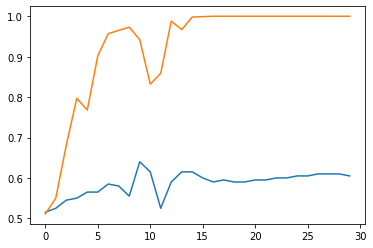

In [14]:
plt.plot(NN.acc_test)
plt.plot(NN.acc_train)
plt.show()

In [15]:
y_hat = NN.predict(X_test.T) 
y_hat = np.round(y_hat.reshape(y_hat.shape[1],))
accuracy_score(y_test, y_hat)

0.605

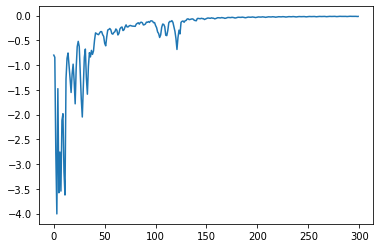

In [16]:
plt.plot(NN.losses_train)